In [288]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,LSTM, Embedding, Dense, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [200]:
Data = pd.read_csv('Data/Wikihow_clean_test')
Data.head()

,Unnamed: 0,headline,title,text,clean_text,cleaned_headline
0,0,"\r\nKeep related supplies in the same area.,\r...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess...",photographer keep necessary lens cords batteri...,keep related supplies in the same area make an...
1,1,\r\nCreate a sketch in the NeoPopRealist manne...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...,see image drawing develops step step however i...,create sketch in the neopoprealist manner of t...
2,2,"\r\nGet a bachelor’s degree.,\r\nEnroll in a s...",How to Be a Visual Effects Artist1,It is possible to become a VFX artist without...,possible become vfx artist without college deg...,get bachelor degree enroll in studio based pro...
3,3,\r\nStart with some experience or interest in ...,How to Become an Art Investor,The best art investors do their research on t...,best art investors research pieces art buy som...,start with some experience or interest in art ...
4,4,"\r\nKeep your reference materials, sketches, a...",How to Be an Organized Artist2,"As you start planning for a project or work, ...",start planning project work likely gathering s...,keep your reference materials sketches article...


In [282]:
X_train, X_test, y_train, y_test = train_test_split(Data['clean_text'], Data['cleaned_headline'], test_size = .2, random_state = 4, shuffle = True) 

In [283]:
max_len_text =400
max_len_summary = 80

In [284]:
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))


X_train = X_tokenizer.texts_to_sequences(X_train)
X_test = X_tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train,  maxlen=max_len_text, padding='post') 
X_test = pad_sequences(X_test, maxlen=max_len_text, padding='post')

x_voc_size = len(X_tokenizer.word_index) +1

In [285]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))


y_train = y_tokenizer.texts_to_sequences(y_train)
y_test = y_tokenizer.texts_to_sequences(y_test)

y_train = pad_sequences(y_train,  maxlen=max_len_summary, padding='post') 
y_test = pad_sequences(y_test, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) +1

In [440]:
from keras import backend as K 

K.clear_session() 

latent_dim = 500 


#Embedding layer
Encoder_inputs = Input(shape=(max_len_text,))

Encoder_embedding = Embedding(x_voc_size, latent_dim,trainable=True)(Encoder_inputs) 


lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True, name = 'lstm1') 

encoder_output1, h1, c1 = lstm1(Encoder_embedding) 


lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True, name = 'lstm2') 

encoder_output2, h2, c2 = lstm2(encoder_output1) 


lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, name = 'lstm3') 

encoder_outputs, h_state, c_state= lstm3(encoder_output2) 


# Decoder

decoder_inputs = Input(shape=(None,))

decoder_embedding = Embedding(y_voc_size, latent_dim,trainable=True)

dec_emb = decoder_embedding(decoder_inputs) 


#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name = 'decoder_lstm') 
decoder_lstm_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[h_state, c_state]) 


#Attention Layer
attention_output = Attention()([decoder_lstm_outputs, encoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis= -1, name='concat_layer')([decoder_lstm_outputs, attention_output])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([Encoder_inputs, decoder_inputs], decoder_outputs) 

In [ ]:
model.summary()

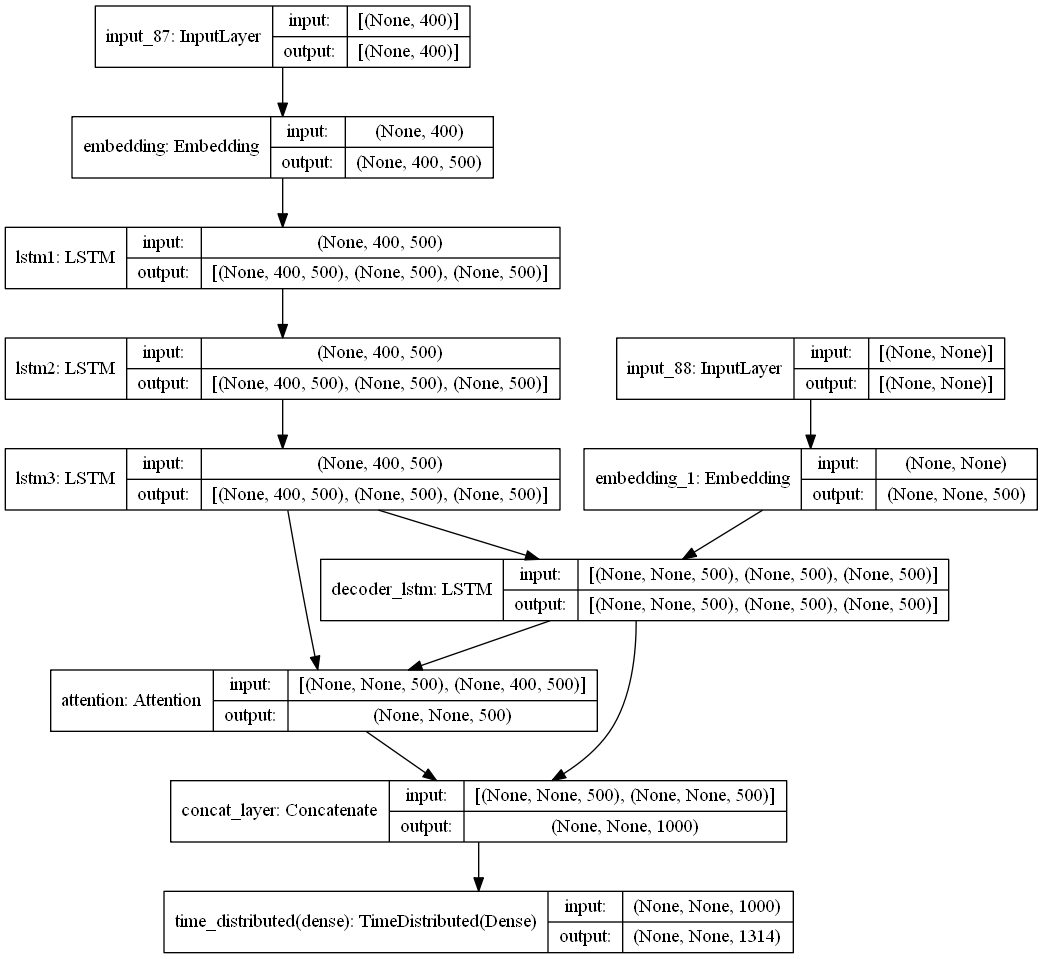

In [443]:
plot_model(model, show_shapes = True,expand_nested = True )

In [395]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [211]:
y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,:1].shape

(80, 1, 1)

In [ ]:
[X_test,y_test[:,-1:]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

In [276]:
y_train.shape

(80, 80)

In [287]:
y_train_reshaped = y_train.reshape(y_train.shape[0], max_len_summary)[:,1:]
y_test_reshaped  =  y_test.reshape(y_test.shape[0] , max_len_summary)[:,1:]

In [396]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
history = model.fit([X_train,y_train[:,:]], y_train, epochs = 10, batch_size = 100, validation_data = ([X_test,y_test[:,:]], y_test))

Epoch 1/10
1/1 [==============================] - 29s 29s/step - loss: 7.1897 - val_loss: 6.5053
Epoch 2/10
1/1 [==============================] - 19s 19s/step - loss: 6.6125 - val_loss: 6.0631
Epoch 3/10
1/1 [==============================] - 20s 20s/step - loss: 6.7712 - val_loss: 5.4600
Epoch 4/10
1/1 [==============================] - 20s 20s/step - loss: 5.6415 - val_loss: 4.7246
Epoch 5/10
1/1 [==============================] - 20s 20s/step - loss: 4.9859 - val_loss: 3.4509
Epoch 6/10
1/1 [==============================] - 20s 20s/step - loss: 3.8540 - val_loss: 3.9837
Epoch 7/10
1/1 [==============================] - 20s 20s/step - loss: 4.5439 - val_loss: 3.8248
Epoch 8/10
1/1 [==============================] - 20s 20s/step - loss: 4.1790 - val_loss: 3.3467
Epoch 9/10
1/1 [==============================] - 20s 20s/step - loss: 3.7545 - val_loss: 3.2981
Epoch 10/10
1/1 [==============================] - 20s 20s/step - loss: 3.7132 - val_loss: 3.2840


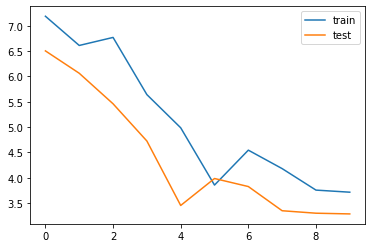

In [397]:
plt.plot(history.history['loss'], label ='train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [398]:
reverse_target_word = y_tokenizer.index_word
reverse_input_word = X_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [474]:
encoder_model = Model(inputs = Encoder_inputs, outputs = [encoder_outputs, h_state, c_state])

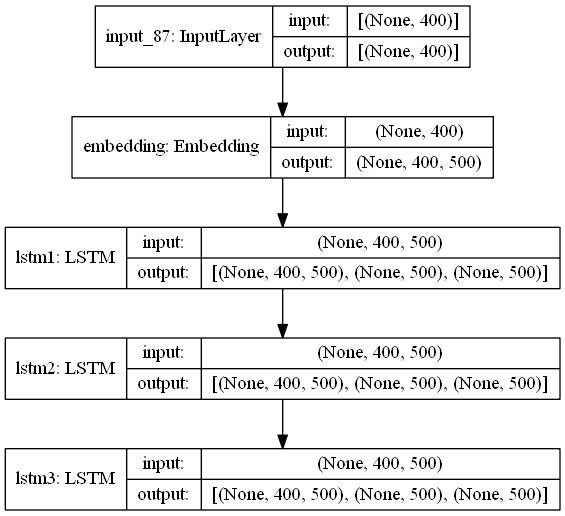

In [476]:
plot_model(encoder_model, show_shapes = True)

In [421]:
decoder_h_state_input = Input(shape=(latent_dim,))
decoder_c_state_input = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

dec_emb2 = decoder_embedding(decoder_inputs)

decoder_outputs2 , h_state2, c_state2  = decoder_lstm(dec_emb2,initial_state=[decoder_h_state_input, decoder_c_state_input], name = 'decoder_lstm2')

attention_output_inf = Attention()([decoder_outputs2, decoder_hidden_state_input]) 

decoder_concat_inf = Concatenate(axis= -1, name='concat')([decoder_outputs2, attention_output_inf])

decoder_outputs2 = decoder_dense(decoder_concat_inf)

decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_h_state_input, decoder_c_state_input],
                     [decoder_outputs2] + [h_state2, c_state2])

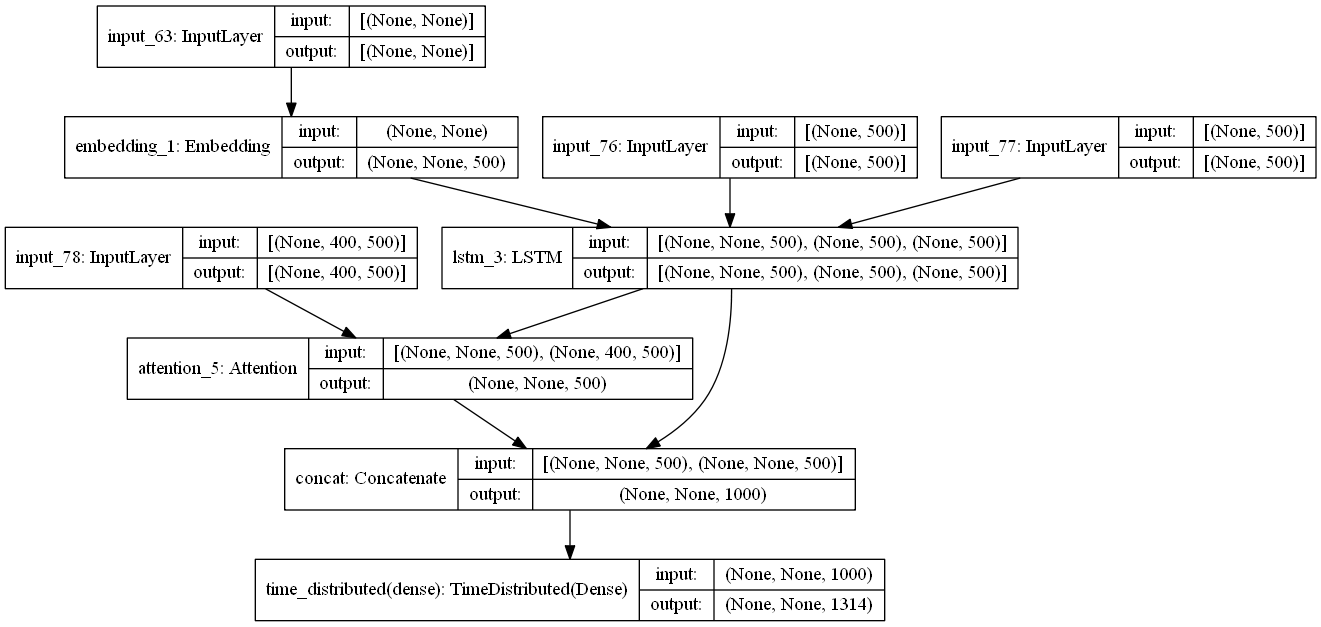

In [423]:
plot_model(decoder_model, show_shapes = True)

In [460]:
h_state_r = np.array([encode_h_state])
c_state_r = np.array([encode_c_state])
encode_output_r =  encode_output.reshape(1,400,500)

(1, 400, 500)

In [468]:
encode_h_state.shape

(400, 500)

In [488]:
encoder_model.predict(X_train[0])[0].shape

(400, 1, 500)

In [466]:
encode_output, encode_h_state, encode_c_state = encoder_model.predict(X_train[0])

encode_h_state_r = np.array([encode_h_state])
encode_c_state_r = np.array([encode_c_state])
encode_output_r =  encode_output.reshape(1,400,500)
    
    
target_seq = np.zeros((1,1))
    
target_seq[0,0] = target_word_index['start']
    
stop_condition = False
decoded_sentence = ''
while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + [encode_output_r, encode_h_state_r, encode_c_state_r])
        
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = reverse_target_word[sampled_token_index]
       
    if(sampled_token!='end'):
        decoded_sentence += ' ' + sampled_token
            
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary - 1)):
                stop_condition = True
                
    target_seq = np.zeros((400,1))
    target_seq[0,0] = sampled_token_index
        
    encode_h_state, encode_c_state = h, c
        
print(decoded_sentence)

ValueError: in user code:

    C:\Users\Allen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1569 predict_function  *
        return step_function(self, iterator)
    C:\Users\Allen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Allen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Allen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Allen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Allen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1552 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Allen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1525 predict_step
        return self(x, training=False)
    C:\Users\Allen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Allen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\input_spec.py:270 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 2 is incompatible with layer model_7: expected shape=(None, 500), found shape=(None, 400, 500)


In [401]:
def decode_sequence(input_seq):
    encode_output, encode_h_state, encoder_c_state = encoder_model.predict(input_seq)
    
    
    target_seq = np.zeros((1,1))
    
    target_seq[0,0] = target_word_index['start']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [encode_output, encode_h_state, encoder_c_state])
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word[sampled_token_index]
        
        if(sampled_token!='end'):
            decoded_sentence += ' ' + sampled_token
            
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary - 1)):
                stop_condition = True
                
        target_seq = np.zeros((1,1))
        target_seq[0,0] = sampled_token_index
        
        encode_h_state, encoder_c_state = h, c
        
    return decoded_sentence

In [312]:
X_train[0].shape

(400,)

In [409]:
decoder_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 500)    657000      input_63[0][0]                   
__________________________________________________________________________________________________
input_67 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_68 (InputLayer)           [(None, 500)]        0                                            
____________________________________________________________________________________________